In [1]:
%%capture
# Compile and import local pyrossgeo module
import os, sys
owd = os.getcwd()
os.chdir('../../')
sys.path.insert(0,'../../')
!python setup.py build_ext --inplace
os.chdir(owd)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyrossgeo

import pandas as pd
import json

We will generate most of the simulation configuration files based on parameters we feed into the simulation.

Warnings about RAM

Allow to have names in the node populations

Explanation about how node pop and commtuer network awas construced.

Explain what age groups we have

Mention that we set `min_num_moving` quite high here for demonstration purposes.

[00:13, 27/05/2020] Jakub: betaEffec:
 array([1.34733454, 3.36833634, 4.71567087, 5.38933814, 6.73667268,
        6.73667268, 6.73667268]
        
[00:13, 27/05/2020] Jakub: For age_groups = [16, 25, 35, 50, 65, 75]

[00:14, 27/05/2020] Jakub: For Lad 5 in my list

[00:14, 27/05/2020] Jakub: sus= np.array([0.2, 0.5, 0.7, 0.8, 1,  1, 1])

[00:15, 27/05/2020] Jakub: (this is the susceptibility to infection upon contact with infected)

[00:15, 27/05/2020] Jakub: beta=betaEffec*sus

[00:15, 27/05/2020] Jakub: Shouldd I put this in some document?

[00:15, 27/05/2020] Jakub: There is quite a lot of it

[01:06, 27/05/2020] Jakub: z=[3,2,2,3,3,2,1]

```
i1, j1 =0, 0
for l in range(M):
    j1=0
    for j in range(M):
        CH[l,j] = np.sum( CH0[i1:i1+z[l], j1:j1+z[l]] )
        CW[l,j] = np.sum( CW0[i1:i1+z[l], j1:j1+z[l]] )
        CS[l,j] = np.sum( CS0[i1:i1+z[l], j1:j1+z[l]] )
        CO[l,j] = np.sum( CO0[i1:i1+z[l], j1:j1+z[l]] )
        j1 = j1+z[j]
    i1 = i1+z[l]
```    
    
[01:07, 27/05/2020] Jakub: Although you might want to split the first one
I have 9 age groups right?
z=[1,1,1,2,2,3,3,2,1]

For your model alpha, betaEffective (contactmatrix as well)

Plan:

- Jakub has to redo the inference but with adjusted contact matrices.
- Use g^\ell instead of g^\ell_{ij}.
- Rescale the contact matrices temporally, but don't try to adjust them based on how many people are working.
- Perhaps implement the rescaling formula directly into pyrossgeo.

# Generate the configuration files

### Configuration generation parameters

Here we define some parameters with which all the configuration files will be generated. Edit these if you want to change the simulation.

Age groups:
0-4, 5-11, 12-15, 16-24, 25-34, 35-49, 50-64, 65-74

In [2]:
sim_config_path = 'covidsim_config'

min_num_moving = 800 # Remove all commuting edges where less than `min_num_moving` are moving

# Decide which classes are allowed to commute
allow_class = [
    ('S', True),
    ('E0', True),
    ('E1', True),
    ('I0', True),
    ('I1', False),
    ('I2', False),
    ('D', True),
    ('R', True),
]

age_groups = 9

# Node parameters

parameter_ranges = {'beta': (0.14,0.17), 'gIk': (0.3,0.5), 'gEk': (0.35,0.45), 'gIkR': (0.15,0.5), 'gIkD': (0.0012,0.0014), 'kI': 3, 'kE': 2}

beta = np.average(parameter_ranges['beta'])
gIk = np.average(parameter_ranges['gIk'])
gEk = np.average(parameter_ranges['gEk'])
gIkR = np.average(parameter_ranges['gIkR'])
gIkD = np.average(parameter_ranges['gIkD'])

# Time steps

t_start = 0
t_end = 24*60*100

_, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  1*60),
    (7*60,  2),
    (10*60, 2*60),
    (17*60, 2),
    (19*60, 2*60)
], end_time=24*60)

### Model

In [3]:
import json

with open('%s/model.json' % sim_config_path, 'r') as f:
    model = json.load(f)   
with open('%s/model.json' % sim_config_path, 'r') as f:
    print(f.read())

{
    "settings" : {
        "classes": ["S", "E0", "E1", "I0", "I1", "I2", "D", "R"],
        "stochastic_threshold_from_below" : [1000, 1000, 1000, 1000, 1000, 1000, 1000],
        "stochastic_threshold_from_above" : [500, 500, 500, 500, 500, 500, 500],
        "contact_scaling" : "powerlaw",
        "contact_scaling_parameters" : [0, 0.004, 0.5] 
    },

    "S" : {
        "linear": [],
        "infection": [["I0", "-beta0"], ["I1", "-beta1"], ["I2", "-beta2"]]
    },

    "E0": {
        "linear": [["E0", "-gEk0"]],
        "infection": [["I0", "beta0"], ["I1", "beta1"], ["I2", "beta2"]]
    },

    "E1": {
        "linear": [["E1", "-gEk1"], ["E0", "gEk0"]],
        "infection": []
    },

    "I0": {
        "linear": [["I0", "-gIk0"], ["E1", "gEk1"]],
        "infection": []
    },

    "I1": {
        "linear": [["I1", "-gIk1"], ["I0", "gIk0"]],
        "infection": []
    },

    "I2": {
        "linear": [["I2", "-gIkR"], ["I1", "gIk1"], ["I2", "-gIkD"]],
        "infection"

### Format the commuting network

In [4]:
cn = pd.read_csv("%s/commuter_networks.csv" % sim_config_path)

#### Set which classes are allowed to commute

# Drop the current allow_O columns
cn = cn.iloc[:,:10]

# Set allow settings
for O, allow_O in allow_class:
    cn[ "Allow %s" % O ] = 1 if allow_O else 0
    
# Allow people to return home
cn.loc[ cn['Home'] == cn['To'],"Allow %s" % allow_class[0][0]:] = 1

#### Remove commuting edges where fewer than `min_num_moving` people are commuting

delete_rows = []

for i, row in cn.loc[ cn['Home'] == cn['From'] ].iterrows():
    if row['# to move'] < min_num_moving:
        delete_rows.append(i)
        delete_rows.append(i+1) # Delete the returning commuting edge as well

cn = cn.reset_index()
cn = cn.drop(delete_rows)
cn = cn.drop(columns='index')

cn.loc[cn['ct1'] == cn['ct2'], 'ct2'] += 0.1

cn.head()

,Home,From,To,Age,# to move,% to move,t1,t2,ct1,ct2,Allow S,Allow E0,Allow E1,Allow I0,Allow I1,Allow I2,Allow D,Allow R
156946,554,554,0,4,863,-1,8.879771,9.000000,9.000000,9.120229,1,1,1,1,0,0,1,1
156947,554,0,554,4,-1,1,17.000000,17.120229,17.120229,17.240458,1,1,1,1,1,1,1,1
196724,701,701,0,4,1054,-1,8.490729,9.000000,9.000000,9.509271,1,1,1,1,0,0,1,1
196725,701,0,701,4,-1,1,17.000000,17.509271,17.509271,18.018543,1,1,1,1,1,1,1,1
217932,779,779,0,4,1105,-1,8.846214,9.000000,9.000000,9.153786,1,1,1,1,0,0,1,1


### Setting the node and cnode parameters

We need to add rows giving the model parameters in `node_parameters.csv` and `cnode_parameters.csv`, which currently only has the areas of each geographical node:

In [5]:
nparam = pd.read_csv('%s/node_parameters.csv' % sim_config_path)

nparam = nparam.append({
    'Home' : 'ALL',
    'Location' : 'ALL',
    'Age' : 'ALL',
    'beta0' : beta,
    'beta1' : beta,
    'beta2' : beta,
    'gEk0' : gEk,
    'gEk1' : gEk,
    'gIk0' : gIk,
    'gIk1' : gIk,
    'gIk2' : gIk,
    'gIkD' : gIkD,
    'gIkR' : gIkR,
}, ignore_index=True)

nparam

,Home,Location,Age,Area,beta0,beta1,beta2,gEk0,gEk1,gIk0,gIk1,gIk2,gIkD,gIkR
0,0,0,ALL,2.905399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,ALL,2.165634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,ALL,2.143565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,ALL,2.490215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,ALL,1.186180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7229,7229,7229,ALL,1325.381099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7230,7230,7230,ALL,5383.759647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7231,7231,7231,ALL,174.621296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7232,7232,7232,ALL,472.309075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
cnparam = pd.read_csv('%s/cnode_parameters.csv' % sim_config_path)

cnparam = cnparam.append({
    'Home' : 'ALL',
    'From' : 'ALL',
    'To' : 'ALL',
    'Age' : 'ALL',
    'beta0' : beta,
    'beta1' : beta,
    'beta2' : beta,
    'gEk0' : gEk,
    'gEk1' : gEk,
    'gIk0' : gIk,
    'gIk1' : gIk,
    'gIk2' : gIk,
    'gIkD' : gIkD,
    'gIkR' : gIkR,
}, ignore_index=True)

cnparam

,Home,From,To,Age,Area,beta0,beta1,beta2,gEk0,gEk1,gIk0,gIk1,gIk2,gIkD,gIkR
0,ALL,ALL,ALL,ALL,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ALL,ALL,ALL,ALL,NaN,0.155,0.155,0.155,0.4,0.4,0.4,0.4,0.4,0.0013,0.325


### Contact matrices

Define the contact matrices

In [7]:
minutes_in_a_day = 24*60

CH0, CW0, CS0, CO0 = np.load('%s/contact_matrices.npy' % sim_config_path) / minutes_in_a_day

C_home = np.zeros((age_groups, age_groups))
C_work = np.zeros((age_groups, age_groups))
C_school = np.zeros((age_groups, age_groups))
C_other = np.zeros((age_groups, age_groups))
z=[1,1,1,2,2,3,3,2,1]
i1, j1 =0, 0
for l in range(age_groups):
    j1=0
    for j in range(age_groups):
        C_home[l,j] = np.sum( CH0[i1:i1+z[l], j1:j1+z[l]] )
        C_work[l,j] = np.sum( CW0[i1:i1+z[l], j1:j1+z[l]] )
        C_school[l,j] = np.sum( CS0[i1:i1+z[l], j1:j1+z[l]] )
        C_other[l,j] = np.sum( CO0[i1:i1+z[l], j1:j1+z[l]] )
        j1 = j1+z[j]
    i1 = i1+z[l] 

# Rescale contact matrices
    
work_hours = 17-9
C_work = C_work * 24 / work_hours
C_school = C_school * 24 / work_hours

# Construct contact matrices
    
C_no_work = C_home + C_other
C_at_work = C_home + C_work + C_school + C_other
C_commute = C_home + C_work + C_school + C_other

contact_matrices = {
    'C' : C_no_work,
    'C_commute' : C_commute
}

In [8]:
ncm = pd.DataFrame(columns=['Home', 'Location'] + model['settings']['classes'])

ncm = ncm.append({
    'Home' : 'ALL',
    'Location' : 'ALL',
    'I0' : 'C',
    'I1' : 'C',
    'I2' : 'C'
}, ignore_index=True)

In [9]:
cncm = pd.DataFrame(columns=['Home', 'From', 'To'] + model['settings']['classes'])

cncm = cncm.append({
    'Home' : 'ALL',
    'From' : 'ALL',
    'To' : 'ALL',
    'I0' : 'C',
    'I1' : 'C',
    'I2' : 'C'
}, ignore_index=True)

In [10]:
minutes_in_day = 24*60*60

def set_work_contact_matrix(sim, step_i, t, dt, X_state, dX_state, X_state_saved, ts_saved, save_i): 
    global C_at_work
    
    tday = t % minutes_in_day
    
    cmat = sim.get_contact_matrix('C')
    cmat[:] = C_at_work
    
def set_no_work_contact_matrix(sim, step_i, t, dt, X_state, dX_state, X_state_saved, ts_saved, save_i): 
    global C_no_work
    
    tday = t % minutes_in_day
    
    cmat = sim.get_contact_matrix('C')
    cmat[:] = C_no_work

### Seed infections

set()


(51.2, 51.7)

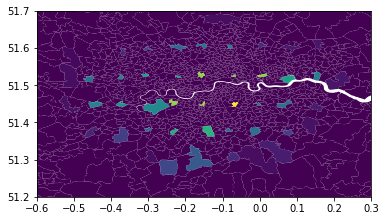

In [11]:
import geopandas as gpd

initial_infections = np.load("%s/covid-sim_seeding.npy" % sim_config_path)

in_lon = initial_infections[0,:]
in_lat = initial_infections[1,:]
in_infected = initial_infections[2,:]

points = [ (in_lon[i], in_lat[i], in_infected[i]) for i in range(len(in_lon)) ]

geometry = gpd.read_file("../geodata/GB_geo/GB.shp")
geometry = geometry.to_crs(epsg=4326)

from shapely.geometry import Point, Polygon

seed_nodes = np.zeros( geometry.shape[0] )

used_points = []

for i, row in geometry.iterrows():
    poly = row['geometry']
    
    for lon, lat, infected in points:
        p = Point(lon, lat)
        
        if p.within(poly):
            seed_nodes[i] += infected
            
            if not p in used_points:
                used_points.append( (lon, lat, infected) )
            else:
                raise Exception()
                
unused_points = set(points) - set(used_points)
print(unused_points)

geometry['I_seed'] = seed_nodes
ax = geometry.plot(column='I_seed')

ax.set_xlim(-0.6, 0.3)
ax.set_ylim(51.2, 51.7)

In [12]:
_node_pop = pd.read_csv('%s/node_populations.csv' % sim_config_path)

node_pop = pd.DataFrame()
node_pop['Home'] = _node_pop['Home']
node_pop['Location'] = _node_pop['Location']

for i in range(age_groups):
    age = _node_pop.columns[2+i]
    
    for j in range(len(model['settings']['classes'])):
        oclass = model['settings']['classes'][j]
        
        if j == 0:
            node_pop["%s(%s)" % (oclass, age)] = _node_pop[age]
        else:
            node_pop["%s(%s)" % (oclass, age)] = 0
            
node_pop["%s(%s)" % ("I1", _node_pop.columns[2+5])] = seed_nodes

## Run simulation

In [13]:
sim = pyrossgeo.Simulation()

X_state = sim.initialize(
    model_dat = '%s/model.json' % sim_config_path,
    commuter_networks_dat = cn,
    node_populations_dat = node_pop,
    node_parameters_dat = nparam,
    cnode_parameters_dat = cnparam,
    contact_matrices_dat = contact_matrices,
    node_cmatrices_dat = ncm,
    cnode_cmatrices_dat = cncm
)

sim.add_event([9*60], set_work_contact_matrix, repeat_time=24*60)
sim.add_event([17*60], set_no_work_contact_matrix, repeat_time=24*60)

sim_data = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=len(dts), steps_per_print=len(dts), only_save_nodes=True, save_path='sim_data')

Step 0 out of 16400
Step 164 out of 16400
Step 328 out of 16400
Step 492 out of 16400
Step 656 out of 16400
Step 820 out of 16400
Step 984 out of 16400
Step 1148 out of 16400
Step 1312 out of 16400
Step 1476 out of 16400


KeyboardInterrupt: 

## Plot the result

Plot the evolution of the whole network

In [14]:
sim_data = pyrossgeo.utils.load_sim_data('sim_data')
location_data = pyrossgeo.utils.extract_location_data(sim_data)
ts = pyrossgeo.utils.extract_ts(sim_data)
ts_days = ts/(24*60)

network_data = np.sum(location_data, axis=3)

In [18]:
network_data.shape

(101, 9, 8)

Text(0.5, 0, 'Days')

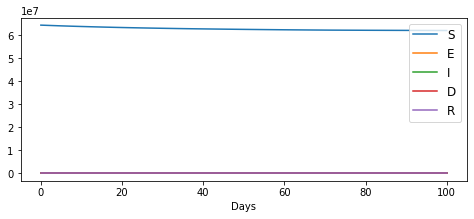

In [30]:
plt.figure( figsize=(8,3) )

S = np.sum(network_data[:,:,0], axis=1)
E0 = np.sum(network_data[:,:,1], axis=1)
E1 = np.sum(network_data[:,:,2], axis=1)
I0 = np.sum(network_data[:,:,3], axis=1)
I1 = np.sum(network_data[:,:,4], axis=1)
I2 = np.sum(network_data[:,:,5], axis=1)
D = np.sum(network_data[:,:,6], axis=1)
R = np.sum(network_data[:,:,7], axis=1)

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, E0+E1, label="E")
plt.plot(ts_days, I0+I1+I2, label="I")
plt.plot(ts_days, D, label="D")
plt.plot(ts_days, R, label="R")

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Days')

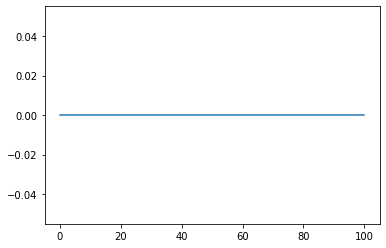

In [28]:
plt.plot(ts_days, R)

### Plotting the result using GeoPandas

Assemble geo data and define helper functions. Edit `plot_frame` to change the format of the video.

In [ ]:
import pickle
import tempfile
import geopandas as gpd
from geopandas.plotting import plot_polygon_collection
from matplotlib import animation

# Simulation data

location_data = pyrossgeo.utils.extract_location_data(sim_data)
ts = pyrossgeo.utils.extract_location_data(sim_data)
N_ = np.sum(location_data[:,:,:,:], axis=(1,2))

S_ = np.sum(location_data[:,:,0,:], axis=1)
E_ = np.sum(location_data[:,:,1,:], axis=1)
A_ = np.sum(location_data[:,:,2,:], axis=1)
Ia1_ = np.sum(location_data[:,:,3,:], axis=1)
Ia2_ = np.sum(location_data[:,:,4,:], axis=1)
Ia3_ = np.sum(location_data[:,:,5,:], axis=1)
Is1_ = np.sum(location_data[:,:,6,:], axis=1)
Is2_ = np.sum(location_data[:,:,7,:], axis=1)
Is3_ = np.sum(location_data[:,:,8,:], axis=1)
R_ = np.sum(location_data[:,:,9,:], axis=1)

s_ = S_ / N_
e_ = E_ / N_
a_ = A_ / N_
ia1_ = Ia1_ / N_
ia2_ = Ia2_ / N_
ia3_ = Ia3_ / N_
is1_ = Is1_ / N_
is2_ = Is2_ / N_
is3_ = Is3_ / N_
r_ = R_ / N_

ts_days = pyrossgeo.utils.extract_ts(sim_data) / (24*60)

epi_data = np.sum(np.array([   # Used to plot pandemic curves
    S_,E_,A_,Ia1_,Ia2_,Ia3_,Is1_,Is2_,Is3_,R_
]), axis=2)

# Load geometry

geometry_node_key = 'msoa11cd'
geometry = gpd.read_file("../geodata/GB_geo/GB.shp")

loc_table = pd.read_csv('%s/loc_table.csv' % sim_config_path)
loc_table_loc_col = loc_table.columns[0]
loc_table_loc_key_col = loc_table.columns[1]
#geometry = geometry[ geometry[geometry_node_key].isin(loc_table.iloc[:,1]) ] # Remove locations in geometry that are not in loc_table
#geometry = geometry.merge(loc_table, left_on=geometry_node_key, right_on=loc_table_loc_key_col) # Add location indices
#geometry = geometry.sort_values(by=loc_table_loc_col) # Sort them by location indices

# Edit this function to adjust the layout of the video

def plot_frame(ti, close_plot=False, tmp_save=None):
    fig, axes = plt.subplots(ncols=4, nrows=3, gridspec_kw={'width_ratios':[1, 1, 1, 1.3]}, figsize=(38, 24))

    geometry['S'] = s_[ti,:]
    geometry['E'] = e_[ti,:]
    geometry['A'] = a_[ti,:]
    geometry['Ia1'] = ia1_[ti,:]
    geometry['Ia2'] = ia2_[ti,:]
    geometry['Ia3'] = ia3_[ti,:]
    geometry['Is1'] = is1_[ti,:]
    geometry['Is2'] = is2_[ti,:]
    geometry['Is3'] = is3_[ti,:]
    geometry['R'] = r_[ti,:]
    
    plot_geo(geometry, axes[0,0], vmin=0, vmax=1, value_key='S', title="Susceptible", legend=False)
    plot_geo(geometry, axes[0,1], vmin=0, vmax=1, value_key='E', title="Exposed", legend=False)
    plot_geo(geometry, axes[0,2], vmin=0, vmax=1, value_key='A', title="Activated", legend=True)
    plot_geo(geometry, axes[0,3], vmin=0, vmax=1, value_key='Ia1', title="Infected", legend=False)
    plot_geo(geometry, axes[1,0], vmin=0, vmax=1, value_key='Ia2', title="Infected", legend=False)
    plot_geo(geometry, axes[1,1], vmin=0, vmax=1, value_key='Ia3', title="Infected", legend=False)
    plot_geo(geometry, axes[1,2], vmin=0, vmax=1, value_key='Is1', title="Infected", legend=False)
    plot_geo(geometry, axes[1,3], vmin=0, vmax=1, value_key='Is2', title="Infected", legend=False)
    plot_geo(geometry, axes[2,0], vmin=0, vmax=1, value_key='Is3', title="Infected", legend=False)
    plot_geo(geometry, axes[2,1], vmin=0, vmax=1, value_key='R', title="Recovered", legend=False)
    
    plot_epi(axes[1,2], ti, ts_days, epi_data, ['S','E','A','Ia1','Ia2','Ia3','Is1','Is2','Is3','R'])
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.92])
    fig.suptitle("SEAIR Model - Day %s" % ti, fontsize=18)
    
    if not tmp_save is None:
        plt.savefig(tmp_save.name + '/%s.png' % ti)
    if close_plot:
        plt.close(fig)
    if not tmp_save is None:
        return tmp_save.name + '/%s.png' % ti

# Helper functions for plotting

def plot_geo(geometry, ax, vmin, vmax, value_key='val', title="", legend=True, legend_label='', cax=None, axis_on=False):
    if legend:
        if cax is None:
            geometry.plot(column=value_key, ax=ax, vmin=vmin, vmax=vmax, legend=True, legend_kwds={'label': legend_label})
        else:
            geometry.plot(column=value_key, ax=ax, cax=cax, vmin=vmin, vmax=vmax, legend=True, legend_kwds={'label': legend_label})
    else:
        geometry.plot(column=value_key, ax=ax, cax=cax, vmin=vmin, vmax=vmax, legend=False)
        
    ax.set_title(title)
    if not axis_on:
        ax.set_axis_off()
        
def plot_epi(ax, ti, ts, epi_data, epi_data_labels):
    for oi in range(epi_data.shape[0]):
        ax.plot(ts[:ti], epi_data[oi,:ti], label=epi_data_labels[oi])
    ax.legend(loc='center left')
    
    ax.set_xlim(np.min(ts_days), np.max(ts_days))
    ax.set_ylim(0, np.max(epi_data))

In [ ]:
network_data = np.sum(location_data, axis=3)

In [ ]:
ts_days = pyrossgeo.utils.extract_ts(sim_data) / (24*60)

plt.figure( figsize=(8,3) )

S = np.sum(network_data[:,:,0], axis=1)
E = np.sum(network_data[:,:,1], axis=1)
A = np.sum(network_data[:,:,2], axis=1)
Ia1 = np.sum(network_data[:,:,3], axis=1)
Ia2 = np.sum(network_data[:,:,4], axis=1)
Ia3 = np.sum(network_data[:,:,5], axis=1)
Is1 = np.sum(network_data[:,:,6], axis=1)
Is2 = np.sum(network_data[:,:,7], axis=1)
Is3 = np.sum(network_data[:,:,8], axis=1)
R = np.sum(network_data[:,:,9], axis=1)

#plt.plot(ts_days, S, label="S")
#plt.plot(ts_days, E, label="E")
#plt.plot(ts_days, A, label="A")
#plt.plot(ts_days, Ia1+Ia2+Ia3, label="Ia")
#plt.plot(ts_days, Is1+Is2+Is3, label="Is")
#plt.plot(ts_days, R, label="R")

#plt.plot(ts_days, Ia3, label="R")
plt.plot(ts_days, Ia3, label="R")

#plt.plot(ts_days, S+E+A+Ia1+Ia2+Ia3+Is1+Is2+Is3+R)

#plt.plot(ts_days, np.sum(network_data[:,:,:], axis=(1,2)))

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Days')

Plot the pandemic at a given day

In [ ]:
day = 50

geometry['S'] = s_[day,:]
geometry['E'] = e_[day,:]
geometry['A'] = a_[day,:]
geometry['Ia1'] = ia1_[day,:]
geometry['Ia2'] = ia2_[day,:]
geometry['Ia3'] = ia3_[day,:]
geometry['Is1'] = is1_[day,:]
geometry['Is2'] = is2_[day,:]
geometry['Is3'] = is3_[day,:]
geometry['R'] = r_[day,:]

fig, ax = plt.subplots(figsize=(7, 5))

plot_geo(geometry, ax, vmin=0, vmax=1, value_key='S', title='Susceptibles at day %s' % day)

In [ ]:
day = 50

plot_frame(day)

Create a video of the pandemic

In [ ]:
tmp_dir = tempfile.TemporaryDirectory()

frames_paths = []

for ti in range(len(ts)):
    if ti % 1 == 0:
        print("Frame %s of %s" % (ti, len(ts)))
    frame_path = plot_frame(ti, close_plot=True, tmp_save=tmp_dir)
    frames_paths.append(frame_path)
    
import cv2

video_name = 'sim_video.mp4'

frame = cv2.imread(frames_paths[0])
height, width, layers = frame.shape
fps = 6
#codec=cv2.VideoWriter_fourcc('D', 'I', 'V', 'X')
codec=cv2.VideoWriter_fourcc(*'DIVX')

video = cv2.VideoWriter(video_name, codec, fps, (width,height))

for frame_path in frames_paths:
    video.write(cv2.imread(frame_path))

cv2.destroyAllWindows()
video.release()